# Modelling

In [1]:
#import dependencies
##sklearn libs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
##nlp libs
from nltk.tokenize import RegexpTokenizer
import spacy
#essential libs
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import regex as re
import numpy as np

%matplotlib inline
plt.style.use('seaborn')

In [114]:
pd.set_option('display.max_columns', 999)

## Read in datasets

In [2]:
df_red = pd.read_csv('../assets/reddit_all.csv')
df_gab = pd.read_csv('../assets/gab_clean.csv')

In [3]:
df_red.drop('Unnamed: 0', axis=1, inplace=True)
df_gab.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df_red.head()

,id,text,hate,response
0,e8q18lf,1. A subsection of retarded Hungarians? Ohh bo...,1,"[""I don't see a reason why it's okay to insult..."
1,e8q9w5s,2. \tHiii. Just got off work. 444 is mainly th...,0,nil
2,e8qbobk,3. \t\twow i guess soyboys are the same in eve...,0,nil
3,e8qfn91,4. \t\t\tOwen Benjamin's soyboy song goes for ...,0,nil
4,e9c6naz,"1. > ""y'all hear sumn?"" by all means I live i...",0,nil


In [5]:
df_gab.head()

,id,text,hate,response
0,39869714,1. i joined gab to remind myself how retarded ...,1,"[""Using words that insult one group while defe..."
1,39845588,1. This is what the left is really scared of. ...,0,['You can disagree with someones opinion witho...
2,39848775,2. \tThat literally looks like a monkey. Why a...,0,['You can disagree with someones opinion witho...
3,39911017,3. \t\tDumb Cunt,1,['You can disagree with someones opinion witho...
4,37485560,1. It makes you an asshole.,0,['Your argument is more rational if you leave ...


In [6]:
print(df_red.shape)
df_gab.shape

(22270, 4)


(33764, 4)

In [7]:
df_red['red'] = 1
df_gab['red'] = 0

In [8]:
df_red['red'].value_counts()

1    22270
Name: red, dtype: int64

In [9]:
df_gab['red'].value_counts()

0    33764
Name: red, dtype: int64

__Combine datasets__

In [10]:
df = df_red.append(df_gab, ignore_index=True)

In [11]:
df.shape

(56034, 5)

In [12]:
df.tail()

,id,text,hate,response,red
56029,38422734,3. \t\tfucking retard,1,['Using words that negatively describes someon...,0
56030,38710847,1. Twitter BANNED me and reported me to the FB...,0,"[""I don't think using words that are sexist in...",0
56031,38711592,2. \tI was routinely suspended for saying fuck...,1,"[""I don't think using words that are sexist in...",0
56032,38718122,3. \t\tThey got me for dropping the cunt bomb....,1,"[""I don't think using words that are sexist in...",0
56033,37951623,1. How absolutely unbelievably fascinating? A ...,1,"[""Using words that derogatorily reference a pa...",0


In [13]:
df['hate'].value_counts()

0    35118
1    20916
Name: hate, dtype: int64

## Pre-processing


In [14]:
def remove_links(x):
#removing links from the set
    return re.sub(r"((http|ftp|https):\/\/)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", x)

In [15]:
#remove links
df['text'] = df['text'].map(remove_links)

In [16]:
#remove tabs
df['text'] = df['text'].map(lambda x: re.sub('\\t+', '', x))

In [17]:
#remove comment number at the front
df['text'] = df['text'].map(lambda x: re.sub('\d+\. ', '', x))

In [18]:
df.tail()

,id,text,hate,response,red
56029,38422734,fucking retard,1,['Using words that negatively describes someon...,0
56030,38710847,Twitter BANNED me and reported me to the FBI f...,0,"[""I don't think using words that are sexist in...",0
56031,38711592,"I was routinely suspended for saying fuck, and...",1,"[""I don't think using words that are sexist in...",0
56032,38718122,They got me for dropping the cunt bomb... a lot.,1,"[""I don't think using words that are sexist in...",0
56033,37951623,How absolutely unbelievably fascinating? A Pak...,1,"[""Using words that derogatorily reference a pa...",0


### Tokenize

In [19]:
from nltk.corpus import stopwords
stopwords_nltk =  set(stopwords.words('english'))
def tokenize_txt(txt):
    #only take words or numbers in
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+', gaps=False)
    tokens = tokenizer.tokenize(txt)
    tokens = [token.lower() for token in tokens if not token.lower() in stopwords_nltk] #lowercase
    return tokens

In [20]:
df['tokens'] = df['text'].map(tokenize_txt)

In [21]:
df.head()

,id,text,hate,response,red,tokens
0,e8q18lf,A subsection of retarded Hungarians? Ohh boy. ...,1,"[""I don't see a reason why it's okay to insult...",1,"[subsection, retarded, hungarians, ohh, boy, b..."
1,e8q9w5s,Hiii. Just got off work. 444 is mainly the typ...,0,nil,1,"[hiii, got, work, mainly, typa, guys, imagine,..."
2,e8qbobk,wow i guess soyboys are the same in every country,0,nil,1,"[wow, guess, soyboys, every, country]"
3,e8qfn91,Owen Benjamin's soyboy song goes for every cou...,0,nil,1,"[owen, benjamin, soyboy, song, goes, every, co..."
4,e9c6naz,"> ""y'all hear sumn?"" by all means I live in a...",0,nil,1,"[hear, sumn, means, live, small, town, rn, wor..."


### Lemmatizing

In [22]:
sp = spacy.load('en_core_web_sm')

In [23]:
def lemma(txt):
    text = sp(txt)
    #get all sentences
    sentence_lst = list(text.sents)
    lemma_words = []
    for sentence in sentence_lst:
        for word in sentence:
            lemma_words.append(word.lemma_)
    #return back as a string        
    return ' '.join(lemma_words)     

In [24]:
df['lemma'] = df['text'].map(lemma)

In [25]:
df.tail(10)

,id,text,hate,response,red,tokens,lemma
56024,37556710,snowflake cunt,1,['Using words that profanely refer to parts of...,0,"[snowflake, cunt]",snowflake cunt
56025,38624662,"#Sweden's four major dailies , , , on #Assang...",0,"['Hey there, derogatory comments are not produ...",0,"[sweden, four, major, dailies, assange, news, ...","# Sweden 's four major daily , , , on # assa..."
56026,38624840,The MSM will never report on themselves or hel...,1,"['Hey there, derogatory comments are not produ...",0,"[msm, never, report, help, solve, problems, to...",the MSM will never report on -PRON- or help to...
56027,38361617,Satisfaction and justice,0,['Using words that negatively describes someon...,0,"[satisfaction, justice]",satisfaction and justice
56028,38421472,BEST TRUMP INSTANT KARMA EVER!,0,['Using words that negatively describes someon...,0,"[best, trump, instant, karma, ever]",BEST TRUMP INSTANT KARMA EVER !
56029,38422734,fucking retard,1,['Using words that negatively describes someon...,0,"[fucking, retard]",fucking retard
56030,38710847,Twitter BANNED me and reported me to the FBI f...,0,"[""I don't think using words that are sexist in...",0,"[twitter, banned, reported, fbi, stating, obvi...",twitter ban -PRON- and report -PRON- to the FB...
56031,38711592,"I was routinely suspended for saying fuck, and...",1,"[""I don't think using words that are sexist in...",0,"[routinely, suspended, saying, fuck, banned, c...","-PRON- be routinely suspend for say fuck , and..."
56032,38718122,They got me for dropping the cunt bomb... a lot.,1,"[""I don't think using words that are sexist in...",0,"[got, dropping, cunt, bomb, lot]",-PRON- get -PRON- for drop the cunt bomb ... a...
56033,37951623,How absolutely unbelievably fascinating? A Pak...,1,"[""Using words that derogatorily reference a pa...",0,"[absolutely, unbelievably, fascinating, pakist...",how absolutely unbelievably fascinating ? a pa...


In [26]:
df.shape

(56034, 7)

In [27]:
df.tail()

,id,text,hate,response,red,tokens,lemma
56029,38422734,fucking retard,1,['Using words that negatively describes someon...,0,"[fucking, retard]",fucking retard
56030,38710847,Twitter BANNED me and reported me to the FBI f...,0,"[""I don't think using words that are sexist in...",0,"[twitter, banned, reported, fbi, stating, obvi...",twitter ban -PRON- and report -PRON- to the FB...
56031,38711592,"I was routinely suspended for saying fuck, and...",1,"[""I don't think using words that are sexist in...",0,"[routinely, suspended, saying, fuck, banned, c...","-PRON- be routinely suspend for say fuck , and..."
56032,38718122,They got me for dropping the cunt bomb... a lot.,1,"[""I don't think using words that are sexist in...",0,"[got, dropping, cunt, bomb, lot]",-PRON- get -PRON- for drop the cunt bomb ... a...
56033,37951623,How absolutely unbelievably fascinating? A Pak...,1,"[""Using words that derogatorily reference a pa...",0,"[absolutely, unbelievably, fascinating, pakist...",how absolutely unbelievably fascinating ? a pa...


In [28]:
## Token lemma
def token_lemma(txt):
    txt = ' '.join(txt)
    text = sp(txt)
    #get all sentences
    sentence_lst = list(text.sents)
    lemma_words = []
    for sentence in sentence_lst:
        for word in sentence:
            lemma_words.append(word.lemma_)
    #return back as a string        
    return ' '.join(lemma_words)   

In [29]:
df['tok_lemma'] = df['tokens'].map(token_lemma)

In [30]:
df.head(1)

,id,text,hate,response,red,tokens,lemma,tok_lemma
0,e8q18lf,A subsection of retarded Hungarians? Ohh boy. ...,1,"[""I don't see a reason why it's okay to insult...",1,"[subsection, retarded, hungarians, ohh, boy, b...",a subsection of retarded Hungarians ? ohh boy ...,subsection retard hungarians ohh boy brace liv...


### Convert to POS tags

In [31]:
#function to convert text to pos tags

def sp_pos_tag(txt):
    post_tag_lst = []
    doc = sp(txt)
    for token in doc:
        post_tag_lst.append(token.tag_)
    return ' '.join(post_tag_lst)

In [32]:
df['pos'] = df['text'].map(sp_pos_tag)

In [33]:
df.shape

(56034, 9)

In [34]:
df.head()

,id,text,hate,response,red,tokens,lemma,tok_lemma,pos
0,e8q18lf,A subsection of retarded Hungarians? Ohh boy. ...,1,"[""I don't see a reason why it's okay to insult...",1,"[subsection, retarded, hungarians, ohh, boy, b...",a subsection of retarded Hungarians ? ohh boy ...,subsection retard hungarians ohh boy brace liv...,DT NN IN JJ NNPS . NN NN . NN IN DT JJ NNP VBG...
1,e8q9w5s,Hiii. Just got off work. 444 is mainly the typ...,0,nil,1,"[hiii, got, work, mainly, typa, guys, imagine,...",hiii . just get off work . 444 be mainly the t...,hiii get work mainly typa guy imagine write -P...,UH . RB VBD RP NN . CD VBZ RB DT NN NNS PRP VB...
2,e8qbobk,wow i guess soyboys are the same in every country,0,nil,1,"[wow, guess, soyboys, every, country]",wow i guess soyboy be the same in every country,wow guess soyboy every country,UH PRP VBP NNS VBP DT JJ IN DT NN
3,e8qfn91,Owen Benjamin's soyboy song goes for every cou...,0,nil,1,"[owen, benjamin, soyboy, song, goes, every, co...",Owen Benjamin 's soyboy song go for every coun...,owen benjamin soyboy song go every country ama...,NNP NNP POS NN NN VBZ IN DT NN CC DT VBZ WRB P...
4,e9c6naz,"> ""y'all hear sumn?"" by all means I live in a...",0,nil,1,"[hear, sumn, means, live, small, town, rn, wor...","> "" -PRON- all hear sumn ? "" by all mean -PR...",hear sumn mean live small town rn work k peopl...,XX `` PRP DT VBP NN . '' _SP IN DT NNS PRP VBP...


### Drop duplicates after pre-processing

In [35]:
df.duplicated(subset=['lemma']).sum()

5676

In [36]:
df.drop_duplicates(subset=['lemma'], inplace=True)

In [37]:
df.duplicated(subset=['lemma']).sum()

0

In [38]:
df.shape

(50358, 9)

__Save to csv__

In [39]:
df.to_csv("../assets/comb_lemma_updated.csv", index=False)

## Baseline accuracy

In [40]:
#baseline score
df['hate'].value_counts(normalize=True)

0    0.610489
1    0.389511
Name: hate, dtype: float64

In [41]:
df.shape

(50358, 9)

In [42]:
df.head()

,id,text,hate,response,red,tokens,lemma,tok_lemma,pos
0,e8q18lf,A subsection of retarded Hungarians? Ohh boy. ...,1,"[""I don't see a reason why it's okay to insult...",1,"[subsection, retarded, hungarians, ohh, boy, b...",a subsection of retarded Hungarians ? ohh boy ...,subsection retard hungarians ohh boy brace liv...,DT NN IN JJ NNPS . NN NN . NN IN DT JJ NNP VBG...
1,e8q9w5s,Hiii. Just got off work. 444 is mainly the typ...,0,nil,1,"[hiii, got, work, mainly, typa, guys, imagine,...",hiii . just get off work . 444 be mainly the t...,hiii get work mainly typa guy imagine write -P...,UH . RB VBD RP NN . CD VBZ RB DT NN NNS PRP VB...
2,e8qbobk,wow i guess soyboys are the same in every country,0,nil,1,"[wow, guess, soyboys, every, country]",wow i guess soyboy be the same in every country,wow guess soyboy every country,UH PRP VBP NNS VBP DT JJ IN DT NN
3,e8qfn91,Owen Benjamin's soyboy song goes for every cou...,0,nil,1,"[owen, benjamin, soyboy, song, goes, every, co...",Owen Benjamin 's soyboy song go for every coun...,owen benjamin soyboy song go every country ama...,NNP NNP POS NN NN VBZ IN DT NN CC DT VBZ WRB P...
4,e9c6naz,"> ""y'all hear sumn?"" by all means I live in a...",0,nil,1,"[hear, sumn, means, live, small, town, rn, wor...","> "" -PRON- all hear sumn ? "" by all mean -PR...",hear sumn mean live small town rn work k peopl...,XX `` PRP DT VBP NN . '' _SP IN DT NNS PRP VBP...


## Model prep

In [223]:
df = pd.read_csv("../assets/comb_lemma_updated.csv")

In [43]:
df.head()

,id,text,hate,response,red,tokens,lemma,tok_lemma,pos
0,e8q18lf,A subsection of retarded Hungarians? Ohh boy. ...,1,"[""I don't see a reason why it's okay to insult...",1,"[subsection, retarded, hungarians, ohh, boy, b...",a subsection of retarded Hungarians ? ohh boy ...,subsection retard hungarians ohh boy brace liv...,DT NN IN JJ NNPS . NN NN . NN IN DT JJ NNP VBG...
1,e8q9w5s,Hiii. Just got off work. 444 is mainly the typ...,0,nil,1,"[hiii, got, work, mainly, typa, guys, imagine,...",hiii . just get off work . 444 be mainly the t...,hiii get work mainly typa guy imagine write -P...,UH . RB VBD RP NN . CD VBZ RB DT NN NNS PRP VB...
2,e8qbobk,wow i guess soyboys are the same in every country,0,nil,1,"[wow, guess, soyboys, every, country]",wow i guess soyboy be the same in every country,wow guess soyboy every country,UH PRP VBP NNS VBP DT JJ IN DT NN
3,e8qfn91,Owen Benjamin's soyboy song goes for every cou...,0,nil,1,"[owen, benjamin, soyboy, song, goes, every, co...",Owen Benjamin 's soyboy song go for every coun...,owen benjamin soyboy song go every country ama...,NNP NNP POS NN NN VBZ IN DT NN CC DT VBZ WRB P...
4,e9c6naz,"> ""y'all hear sumn?"" by all means I live in a...",0,nil,1,"[hear, sumn, means, live, small, town, rn, wor...","> "" -PRON- all hear sumn ? "" by all mean -PR...",hear sumn mean live small town rn work k peopl...,XX `` PRP DT VBP NN . '' _SP IN DT NNS PRP VBP...


In [44]:
X = df['tok_lemma']
y = df['hate']

In [45]:
X.shape

(50358,)

In [46]:
X[:10]

0     subsection retard hungarians ohh boy brace liv...
1     hiii get work mainly typa guy imagine write -P...
2                        wow guess soyboy every country
3     owen benjamin soyboy song go every country ama...
4     hear sumn mean live small town rn work k peopl...
5                                                remove
6     ah liberal slip tell first question ask load r...
14    defender whatever group diverse group since kn...
15                                      inclusive white
16    harvard work inclusive oh accept student next ...
Name: tok_lemma, dtype: object

In [47]:
df.dtypes

id           object
text         object
hate          int64
response     object
red           int64
tokens       object
lemma        object
tok_lemma    object
pos          object
dtype: object

### Train test split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=28)

In [49]:
y_train.value_counts()

0    23057
1    14711
Name: hate, dtype: int64

## BOW Modelling

### Pipeline

In [50]:
from nltk.corpus import stopwords
stopwords_nltk =  set(stopwords.words('english'))

def superPipeline(Dataframes,Vectorizerlist,ClassifierList,Dfnames,pipe_params,methodgridname, df_column):
    Methodgrid=[]
    metnum=len(Dataframes)*len(Vectorizerlist)*len(ClassifierList)
    n=0
    for index,df in enumerate(Dataframes):
        X=Dataframes[index][df_column]
        y=Dataframes[index]['hate']
        X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=28)

        for Vectorizer in Vectorizerlist:
            for Classifier in ClassifierList:
                n+=1
                print(f'{n} of {metnum} of methods attempting')
                method={}
                pipe = Pipeline([
                    ('vec', Vectorizer ),
                    ('class', Classifier)
                ])

                gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5,verbose=1,n_jobs=-1, scoring='f1')
                gs.fit(X_train, y_train)
                method=(gs.best_params_)
                method['Cross_Val_Score']=(gs.best_score_)
                method['Test_Score']=gs.score(X_test,y_test)
                method['Vectorizer']=str(Vectorizer).split('(')[0]
                method['Data']=str(Dfnames[index])
                method['Classifier']=str(Classifier).split('(')[0]
                Methodgrid.append(method)
                
                tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel()
                print(f"{str(Classifier).split('(')[0]} Confusion Matrix:")
                print(f"True Negatives: {tn}")
                print(f"False Positives: {fp}")
                print(f"False Negatives: {fn}")
                print(f"True Positives: {tp}")
                print('\n')
                
                report = classification_report(y_test, gs.predict(X_test), target_names=['Predict 0', 'Predict 1'], output_dict=True)
                class_table = pd.DataFrame(report).transpose()
                display(class_table)
                
    Methodgrid=pd.DataFrame(Methodgrid)
    Methodgrid.to_csv(methodgridname,index=False)
    return Methodgrid

#### Choosing best vectorizer

In [146]:
dataframes=[df]
df_names = ['df']
vectorizer_lst = [TfidfVectorizer(),CountVectorizer()]
classifier_lst = [LogisticRegression(), MultinomialNB()]
pipe_params = {
                    'vec__max_features': [int(i) for i in np.linspace(5000,20000,4)],
                    'vec__min_df': [2],
                    'vec__max_df': [.95],
                    'vec__ngram_range': [(1,1),(1,2)],
                    'vec__stop_words':[stopwords_nltk]
                }
superPipeline(dataframes, vectorizer_lst, classifier_lst, df_names, pipe_params, 'vectorizer_grid.csv')

1 of 4 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression Confusion Matrix:
True Negatives: 7364
False Positives: 322
False Negatives: 1136
True Positives: 3769


2 of 4 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.0min finished


MultinomialNB Confusion Matrix:
True Negatives: 7188
False Positives: 498
False Negatives: 1804
True Positives: 3101


3 of 4 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.4min finished
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression Confusion Matrix:
True Negatives: 7219
False Positives: 467
False Negatives: 925
True Positives: 3980


4 of 4 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min finished


MultinomialNB Confusion Matrix:
True Negatives: 6309
False Positives: 1377
False Negatives: 874
True Positives: 4031




,Classifier,Cross_Val_Score,Data,Test_Score,Vectorizer,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range,vec__stop_words
0,LogisticRegression,0.882397,df,0.884203,TfidfVectorizer,0.95,5000,2,"(1, 1)","{whom, me, until, m, couldn, you'd, her, but, ..."
1,MultinomialNB,0.810966,df,0.817171,TfidfVectorizer,0.95,5000,2,"(1, 2)","{whom, me, until, m, couldn, you'd, her, but, ..."
2,LogisticRegression,0.886686,df,0.889445,CountVectorizer,0.95,20000,2,"(1, 1)","{whom, me, until, m, couldn, you'd, her, but, ..."
3,MultinomialNB,0.821159,df,0.821222,CountVectorizer,0.95,5000,2,"(1, 1)","{whom, me, until, m, couldn, you'd, her, but, ..."


Generally CountVectorizer is better and it does better on unigrams. This is probably because of the type of words that are being used to classify if it is hate speech or not. 

#### Choosing best vectorizer with SVC

In [131]:
dataframes=[df]
df_names = ['df']
vectorizer_lst = [TfidfVectorizer(),CountVectorizer()]
classifier_lst = [SVC()]
pipe_params = {
                    'vec__max_features': [int(i) for i in np.linspace(5000,20000,4)],
                    'vec__min_df': [2],
                    'vec__max_df': [.95],
                    'vec__ngram_range': [(1,1),(1,2),(1,3)],
                    'vec__stop_words':[stopwords_nltk]
                }
superPipeline(dataframes, vectorizer_lst, classifier_lst, df_names, pipe_params, 'vectorizer_grid_linearmodels.csv', 'tok_lemma')

1 of 2 of methods attempting
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/clementow/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 39.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 54.3min finished
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predict

SVC Confusion Matrix:
True Negatives: 7686
False Positives: 0
False Negatives: 4905
True Positives: 0




/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,f1-score,precision,recall,support
Predict 0,0.758100,0.610436,1.000000,7686.000000
Predict 1,0.000000,0.000000,0.000000,4905.000000
accuracy,0.610436,0.610436,0.610436,0.610436
macro avg,0.379050,0.305218,0.500000,12591.000000
weighted avg,0.462772,0.372632,0.610436,12591.000000


2 of 2 of methods attempting
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/clementow/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 44.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 64.7min finished
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC Confusion Matrix:
True Negatives: 7624
False Positives: 62
False Negatives: 3498
True Positives: 1407




,f1-score,precision,recall,support
Predict 0,0.810719,0.685488,0.991933,7686.000000
Predict 1,0.441481,0.957794,0.286850,4905.000000
accuracy,0.717258,0.717258,0.717258,0.717258
macro avg,0.626100,0.821641,0.639392,12591.000000
weighted avg,0.666877,0.791569,0.717258,12591.000000


,Classifier,Cross_Val_Score,Data,Test_Score,Vectorizer,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range,vec__stop_words
0,SVC,0.000000,df,0.000000,TfidfVectorizer,0.95,5000,2,"(1, 1)","{doesn't, under, was, were, down, against, out..."
1,SVC,0.258985,df,0.441481,CountVectorizer,0.95,5000,2,"(1, 3)","{doesn't, under, was, were, down, against, out..."


With SVM Classifier (SVC), it is the same as the other classifiers above where CountVectorizer works better. 

#### Choosing best model based on CountVectorizer

With CountVectorizer as the determined vectorizer, it is time to choose the best model that works well with it. 

In [151]:
def superPipeline(Dataframes,Vectorizerlist,ClassifierList,Dfnames,pipe_params,methodgridname, df_column):
'''
Function that handles the pipeline to match each vectorizer with each classifer with their corresponding 
parameters for GridSearch.
'''
    Methodgrid=[]
    metnum=len(Dataframes)*len(Vectorizerlist)*len(ClassifierList)
    n=0
    for index,df in enumerate(Dataframes):
        X=Dataframes[index][df_column]
        y=Dataframes[index]['hate']
        X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=28)

        for Vectorizer in Vectorizerlist:
            for Classifier in ClassifierList:
                n+=1
                print(f'{n} of {metnum} of methods attempting')
                method={}
                pipe = Pipeline([
                    ('vec', Vectorizer ),
                    ('class', Classifier)
                ])

                gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5,verbose=1,n_jobs=1, scoring='f1')
                gs.fit(X_train, y_train)
                method=(gs.best_params_)
                method['Cross_Val_Score']=(gs.best_score_)
                method['Test_Score']=gs.score(X_test,y_test)
                method['Vectorizer']=str(Vectorizer).split('(')[0]
                method['Data']=str(Dfnames[index])
                method['Classifier']=str(Classifier).split('(')[0]
                Methodgrid.append(method)
                
                tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel()
                print(f"{str(Classifier).split('(')[0]} Confusion Matrix:")
                print(f"True Negatives: {tn}")
                print(f"False Positives: {fp}")
                print(f"False Negatives: {fn}")
                print(f"True Positives: {tp}")
                print('\n')
                
                report = classification_report(y_test, gs.predict(X_test), target_names=['Predict 0', 'Predict 1'], output_dict=True)
                class_table = pd.DataFrame(report).transpose()
                display(class_table)
                
    Methodgrid=pd.DataFrame(Methodgrid)
    Methodgrid.to_csv(methodgridname,index=False)
    return Methodgrid

In [148]:
dataframes=[df]
df_names = ['df']
vectorizer_lst = [CountVectorizer()]
classifier_lst = [LogisticRegression(), MultinomialNB(), ExtraTreesClassifier()]
pipe_params = {
                    'vec__max_features': [int(i) for i in np.linspace(5000,20000,4)],
                    'vec__min_df': [2],
                    'vec__max_df': [.95],
                    'vec__ngram_range': [(1,1),(1,2)],
                    'vec__stop_words':[stopwords_nltk]
                }
superPipeline(dataframes, vectorizer_lst, classifier_lst, df_names, pipe_params, 'class_grid.csv', 'lemma')

1 of 3 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.6min finished
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression Confusion Matrix:
True Negatives: 7219
False Positives: 467
False Negatives: 925
True Positives: 3980




,f1-score,precision,recall,support
Predict 0,0.912066,0.886419,0.939240,7686.000000
Predict 1,0.851155,0.894985,0.811417,4905.000000
accuracy,0.889445,0.889445,0.889445,0.889445


2 of 3 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   59.2s finished


MultinomialNB Confusion Matrix:
True Negatives: 6309
False Positives: 1377
False Negatives: 874
True Positives: 4031




,f1-score,precision,recall,support
Predict 0,0.848611,0.878324,0.820843,7686.000000
Predict 1,0.781732,0.745377,0.821814,4905.000000
accuracy,0.821222,0.821222,0.821222,0.821222


3 of 3 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.9min finished
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier Confusion Matrix:
True Negatives: 7092
False Positives: 594
False Negatives: 1048
True Positives: 3857




,f1-score,precision,recall,support
Predict 0,0.896247,0.871253,0.922717,7686.000000
Predict 1,0.824498,0.866547,0.786340,4905.000000
accuracy,0.869589,0.869589,0.869589,0.869589


,Classifier,Cross_Val_Score,Data,Test_Score,Vectorizer,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range,vec__stop_words
0,LogisticRegression,0.886686,df,0.889445,CountVectorizer,0.95,20000,2,"(1, 1)","{whom, me, until, m, couldn, you'd, her, but, ..."
1,MultinomialNB,0.821159,df,0.821222,CountVectorizer,0.95,5000,2,"(1, 1)","{whom, me, until, m, couldn, you'd, her, but, ..."
2,ExtraTreesClassifier,0.866697,df,0.869589,CountVectorizer,0.95,15000,2,"(1, 2)","{whom, me, until, m, couldn, you'd, her, but, ..."


As we can see the best F1 score still goes to LogisticRegression at `88.16%` and unigram CountVectorizer.
The model with the lowest False Negatives is Multinomial Naive-Bayes whoever the score is the worse out of the above classifiers. 
Coming in second for the lowest False Negatives goes to the LogisticRegression model. 

#### SVC Optimization

So far LogisticRegression model works the best for this dataset classifying whether a comment is hate speech or not. 
Let's use another linear based model to see if the score can further improved. 

In [152]:
dataframes=[df]
df_names = ['df']
vectorizer_lst = [CountVectorizer(max_df=0.95, min_df=2, ngram_range=(1,1))]
classifier_lst = [SVC()]
pipe_params = {
                'class__C':[0.1,1,10]
                }

superPipeline(dataframes, vectorizer_lst, classifier_lst, df_names, pipe_params, 'svm.csv', 'tok_lemma')

1 of 1 of methods attempting
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/clementow/anaconda3/lib/python3.7/s

SVC Confusion Matrix:
True Negatives: 7407
False Positives: 279
False Negatives: 1291
True Positives: 3614




,f1-score,precision,recall,support
Predict 0,0.904175,0.851575,0.963700,7686.000000
Predict 1,0.821550,0.928333,0.736799,4905.000000
accuracy,0.875308,0.875308,0.875308,0.875308
macro avg,0.862863,0.889954,0.850250,12591.000000
weighted avg,0.871987,0.881477,0.875308,12591.000000


,Classifier,Cross_Val_Score,Data,Test_Score,Vectorizer,class__C
0,SVC,0.792316,df,0.82155,CountVectorizer,10


The SVC model has an F1 score of `86.29%` which is considered a decent score but still short of the LogisticRegression performance (`88.16%` before optimization). Though it did better in terms of False Positives, it failed to detect many comments which were considered hate speech which resulted in a high occurence of False Negatives. 

#### Ensemble models

Next we will try ensemble models to see how well it does and if it can be a decent contender to LogisticRegression so far. 

In [38]:
dataframes=[df]
df_names = ['df']
vectorizer_lst = [CountVectorizer()]
classifier_lst = [RandomForestClassifier(n_estimators=100), GradientBoostingClassifier(n_estimators=100), AdaBoostClassifier(n_estimators=100)]
pipe_params = {
                    'vec__max_features': [int(i) for i in np.linspace(5000,20000,4)],
                    'vec__min_df': [2],
                    'vec__max_df': [.95],
                    'vec__ngram_range': [(1,1),(1,2)],
                    'vec__stop_words':[stopwords_nltk]
                }
superPipeline(dataframes, vectorizer_lst, classifier_lst, df_names, pipe_params, 'class_ensemble_grid.csv')

1 of 3 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 34.0min finished


RandomForestClassifier Confusion Matrix:
True Negatives: 7126
False Positives: 559
False Negatives: 842
True Positives: 4064




,precision,recall,f1-score,support
Predict 0,0.894327,0.927261,0.910496,7685.00000
Predict 1,0.879083,0.828373,0.852975,4906.00000
accuracy,0.888730,0.888730,0.888730,0.88873


2 of 3 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.9min finished


GradientBoostingClassifier Confusion Matrix:
True Negatives: 7329
False Positives: 356
False Negatives: 1016
True Positives: 3890




,precision,recall,f1-score,support
Predict 0,0.878250,0.953676,0.914410,7685.000000
Predict 1,0.916156,0.792907,0.850087,4906.000000
accuracy,0.891033,0.891033,0.891033,0.891033


3 of 3 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.0min finished


AdaBoostClassifier Confusion Matrix:
True Negatives: 7282
False Positives: 403
False Negatives: 927
True Positives: 3979




,precision,recall,f1-score,support
Predict 0,0.887075,0.947560,0.916321,7685.000000
Predict 1,0.908033,0.811048,0.856804,4906.000000
accuracy,0.894369,0.894369,0.894369,0.894369


,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range,vec__stop_words,Cross_Val_Score,Test_Score,Vectorizer,Data,Classifier
0,0.95,15000,2,"(1, 2)","{hers, you'll, ain, being, shouldn, isn't, aga...",0.861168,0.852975,CountVectorizer,df,RandomForestClassifier
1,0.95,20000,2,"(1, 1)","{hers, you'll, ain, being, shouldn, isn't, aga...",0.856908,0.850087,CountVectorizer,df,GradientBoostingClassifier
2,0.95,10000,2,"(1, 2)","{hers, you'll, ain, being, shouldn, isn't, aga...",0.861670,0.856804,CountVectorizer,df,AdaBoostClassifier


Adaboost does the best among all the ensemble models with a F1 score of `88.66%`. However we want to ensure the model does well to reduce false negatives, hence RandomForest classifier is superior with a lower number of false negatives and a decent F1 score of `88.17%`. This slightly edges LogisticRegression (before optimization) by `0.01%`.

#### RandomForest optimization

Since RandomForest and LogisticRegression are the top 2 models edging very close with each other. We shall do some optimization of parameters for each model.

In [26]:
dataframes=[df]
df_names = ['df']
vectorizer_lst = [CountVectorizer(max_features=15000, max_df=0.95, min_df=2, ngram_range=(1,2), stop_words=stopwords_nltk)]
classifier_lst = [RandomForestClassifier()]
pipe_params = {
               'class__n_estimators': [10, 100, 200],
               'class__max_depth': [None, 1, 3, 5, 7, 9], 
               'class__max_features': [3, 5, 6]
                }
superPipeline(dataframes, vectorizer_lst, classifier_lst, df_names, pipe_params, 'class_rf_grid.csv')

1 of 1 of methods attempting
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/di

RandomForestClassifier Confusion Matrix:
True Negatives: 7448
False Positives: 237
False Negatives: 1877
True Positives: 3029




,precision,recall,f1-score,support
Predict 0,0.798713,0.969161,0.875720,7685.000000
Predict 1,0.927434,0.617407,0.741312,4906.000000
accuracy,0.832102,0.832102,0.832102,0.832102


,class__max_depth,class__max_features,class__n_estimators,Cross_Val_Score,Test_Score,Vectorizer,Data,Classifier
0,None,6,200,0.735024,0.741312,CountVectorizer,df,RandomForestClassifier


With an increased number of estimators, we want to ensure that it generalises well with unseen data. However, it compromises on the F1 score and recall, esp on classifying hate speech. 

#### Logistic Regression optimization

In [152]:
dataframes=[df]
df_names = ['df']
vectorizer_lst = [CountVectorizer()]
classifier_lst = [LogisticRegression()]
pipe_params = {

                    'vec__max_features': [10000,15000,17500,None],
                    'vec__min_df': [2,3],
                    'vec__max_df': [.95,.9],
                    'vec__ngram_range': [(1,1), (1,2),(1,3)],
                    'vec__stop_words':[stopwords_nltk],
                    'class__C':[0.1,1,10]
                }

superPipeline(dataframes, vectorizer_lst, classifier_lst, df_names, pipe_params, 'logreg.csv')

1 of 1 of methods attempting
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 44.0min finished
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression Confusion Matrix:
True Negatives: 7319
False Positives: 367
False Negatives: 949
True Positives: 3956




,f1-score,precision,recall,support
Predict 0,0.917513,0.885220,0.952251,7686.000000
Predict 1,0.857391,0.915105,0.806524,4905.000000
accuracy,0.895481,0.895481,0.895481,0.895481


,Classifier,Cross_Val_Score,Data,Test_Score,Vectorizer,class__C,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range,vec__stop_words
0,LogisticRegression,0.853168,df,0.857391,CountVectorizer,0.1,0.95,10000,3,"(1, 1)","{whom, me, until, m, couldn, you'd, her, but, ..."


After optimization, LogisticRegression is the superior model with a better F1 score with its results being more interpretable. It also generalises better with unseen data as compared to RandomForest. 

#### Modelling using POS Tags

By classifying hate speech on our dataset, we want to see if there is any relation to how the insults are structured grammatically, which can be used as our features for classification. 

##### Pre-processing

In [439]:
X = df['pos']
y = df['hate']

In [440]:
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y, stratify=y, random_state=28)

In [445]:
y_train_pos.value_counts(normalize=True)

0    0.610389
1    0.389611
Name: hate, dtype: float64

##### Modelling

We want to see if there are any relations to effective clasification by increasing the ngram range for the vectorizers.

In [451]:
dataframes=[df]
df_names = ['df']
vectorizer_lst = [TfidfVectorizer(), CountVectorizer()]
classifier_lst = [LogisticRegression()]
pipe_params = {

                    'vec__max_features': [10000,15000,17500,None],
                    'vec__min_df': [2,3],
                    'vec__max_df': [.95,.9],
                    'vec__ngram_range': [(1,1), (1,2),(1,3), (1,4), (1,5)],
                    'vec__stop_words':[stopwords_nltk],
                    'class__C':[0.1,1,10]
                }

superPipeline(dataframes, vectorizer_lst, classifier_lst, df_names, pipe_params, 'logreg_pos_ngram.csv', 'pos')

1 of 2 of methods attempting
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 38.1min
/Users/clementow/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 63.3min finished
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression Confusion Matrix:
True Negatives: 5701
False Positives: 1985
False Negatives: 2935
True Positives: 1970




,f1-score,precision,recall,support
Predict 0,0.698566,0.660144,0.741738,7686.000000
Predict 1,0.444695,0.498104,0.401631,4905.000000
accuracy,0.609245,0.609245,0.609245,0.609245


2 of 2 of methods attempting
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 52.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 90.7min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 145.6min finished
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/clementow/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression Confusion Matrix:
True Negatives: 6244
False Positives: 1442
False Negatives: 3388
True Positives: 1517




,f1-score,precision,recall,support
Predict 0,0.721099,0.648256,0.812386,7686.000000
Predict 1,0.385809,0.512673,0.309276,4905.000000
accuracy,0.616393,0.616393,0.616393,0.616393


,Classifier,Cross_Val_Score,Data,Test_Score,Vectorizer,class__C,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range,vec__stop_words
0,LogisticRegression,0.447407,df,0.444695,TfidfVectorizer,10,0.95,10000,3,"(1, 5)","{whom, me, until, m, couldn, you'd, her, but, ..."
1,LogisticRegression,0.413341,df,0.385809,CountVectorizer,1,0.95,10000,3,"(1, 3)","{whom, me, until, m, couldn, you'd, her, but, ..."


The above gridsearch results shows that there is no obvious relation that the model can learn from in terms of POS tags of the sentences in the hate speech comments. This is likely due to the fact that most of them are actually grammatically structured in the same way whether is it hate speech or not. 

### Models with best parameters

In [75]:
def print_results(model, pred):

    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test_cvec)).ravel()
    print(f"{str(model).split('(')[0]} Confusion Matrix:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print('\n')

    report = classification_report(y_test, pred, target_names=['Predict 0', 'Predict 1'], output_dict=True)
    class_table = pd.DataFrame(report).transpose()
    display(class_table)

In [93]:
X=df['tok_lemma']
y=df['hate']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=28)

#### Logistic Regression

In [98]:
cvec = CountVectorizer(max_df=0.95, max_features=10000, min_df=3, ngram_range=(1,1))
logreg = LogisticRegression(C=1.0)

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)
logreg.fit(X_train_cvec, y_train)
pred_lr = logreg.predict(X_test_cvec)

/Users/clementow/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [99]:
print_results(logreg, pred_lr)

LogisticRegression Confusion Matrix:
True Negatives: 7183
False Positives: 503
False Negatives: 920
True Positives: 3984




,precision,recall,f1-score,support
Predict 0,0.886462,0.934556,0.909874,7686.000000
Predict 1,0.887898,0.812398,0.848472,4904.000000
accuracy,0.886974,0.886974,0.886974,0.886974
macro avg,0.887180,0.873477,0.879173,12590.000000
weighted avg,0.887021,0.886974,0.885957,12590.000000


#### Logistic Regression with balanced classes

In [102]:
def get_class_weights(y):
    majority = max(y.value_counts())
    return  {cls: float(majority/count) for cls, count in enumerate(y.value_counts())}

class_weights = get_class_weights(y)
class_weights

{0: 1.0, 1: 1.5673209278613307}

In [107]:
cvec = CountVectorizer(max_df=0.95, max_features=10000, min_df=3, ngram_range=(1,1))
logreg_bal = LogisticRegression(C=1.0, class_weight=class_weights)

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)
logreg_bal.fit(X_train_cvec, y_train)
pred_lr_bal = logreg_bal.predict(X_test_cvec)

/Users/clementow/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [108]:
print_results(logreg_bal, pred_lr_bal)

LogisticRegression Confusion Matrix:
True Negatives: 7063
False Positives: 623
False Negatives: 845
True Positives: 4059




,precision,recall,f1-score,support
Predict 0,0.893146,0.918944,0.905861,7686.0000
Predict 1,0.866937,0.827692,0.846860,4904.0000
accuracy,0.883400,0.883400,0.883400,0.8834
macro avg,0.880042,0.873318,0.876361,12590.0000
weighted avg,0.882937,0.883400,0.882879,12590.0000


#### Best Model Comparison Summary

|                                         | F1 score | Recall |
|-----------------------------------------|----------|--------|
| Logistic Regression                     | 87.91%   | 87.35% |
| Logistic Regression with class weights | 87.64%   | 87.33% |

Logistic Regression without class weights is the best performing one with an F1 score of `87.91%` and the best recall. 

__Save best model to disk__

In [109]:
import pickle
filename = '../models/finalized_logreg.sav'
pickle.dump(logreg, open(filename, 'wb'))


from sklearn.externals import joblib
joblib.dump(logreg,'../models/finalized_logreg.pkl')
joblib.dump(logreg, '/Users/clementow/virtualenvs/venv/finalized_logreg.pkl') 

/Users/clementow/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['/Users/clementow/virtualenvs/venv/finalized_logreg.pkl']

#### Best Model Intepretation

In [112]:
coefs=logreg.coef_[0]

word_coef = pd.DataFrame({'word': cvec.get_feature_names() , 'coeff': np.exp(coefs)})

print("Top 50 Features for Logistic Regression & CVec on Hate = 1")
word_coef.sort_values(by='coeff' , ascending=False).head(50)

Top 50 Features for Logistic Regression & CVec on Hate = 1


,word,coeff
6017,nigger,376.591530
3113,faggot,363.563494
7510,retard,161.153371
7512,retarded,139.822428
2057,cunt,100.222272
8388,spic,85.527322
5872,muzzie,79.058264
9730,wetback,72.413391
3111,fag,66.935363
2701,dyke,45.077296


The model is learning that many different offensive words that are actually contributing to hate speech. This is the reason why Logistic Regression has been the go to classifier for so many years with reasonable performances.

But of course, ideally to reach above 90% perhaps a context based classifier might be useful to reduce the False Negatives. 

The reason why unigram for the CountVectorizer is most useful for the classifier to make a decision is likely because of the fact that most offensive words come in a single word which are highly probable to be hate speech related.  

In [111]:
print("Top 20 Features for Logistic Regression & CVec on Hate = 0")
word_coef.sort_values(by='coeff' , ascending=True).head(20)

Top 20 Features for Logistic Regression & CVec on Hate = 0


,word,coeff
9475,van,0.102721
952,boat,0.133900
6277,organisation,0.147655
2350,detail,0.172020
5363,manipulate,0.175165
1288,carter,0.183946
1187,butch,0.200971
6476,pastor,0.203492
2916,er,0.207313
128,adoption,0.207375


For comments that contain unigrams that are not classifed as hate speech, they are usually non-offensive. Of course, given more context, they may or may not be hate speech related. 

### Best Model Misclassifications

In [115]:
X=df[['text', 'response']]
y=df['hate']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=28)
pred_df = pd.DataFrame()

pred_df['comment']=X_test['text']

In [116]:
pred_df['response']=X_test['response']

In [117]:
pred_df['pred'] = pred_lr

In [118]:
pred_df['actual'] = y_test

In [119]:
pred_prob_lr = [i[1] for i in logreg.predict_proba(X_test_cvec)]

In [120]:
pred_df['pred_probs'] = pred_prob_lr

In [121]:
pred_df.head()

,comment,response,pred,actual,pred_probs
55105,Flake is a raging faggot for his behavior duri...,['You should respect others no matter their se...,1,1,0.978610
42975,#England is the cowardly lion,"['Good grief, every woman in power a ""d"" to yo...",0,0,0.034907
34650,"Poll: Republicans May See Bump In Turnout, Ins...",['Labeling a party with terms that give stereo...,0,0,0.023520
5894,"Surely rednecks are hardly ever incels, becaus...","[""It's very hard to follow your argument when ...",0,0,0.078091
34156,Great working dealing with those faggot shills...,"['Shills is tough enough language, thanks! Als...",1,1,0.982237


In [122]:
#look into false negatives
lr_fn_df = pred_df[(pred_df['pred'] == 0) & (pred_df['actual'] == 1)]
#look into false postives
lr_fp_df = pred_df[(pred_df['pred'] == 1) & (pred_df['actual'] == 0)]

In [123]:
lr_fn_df.reset_index(inplace=True)
lr_fp_df.reset_index(inplace=True)

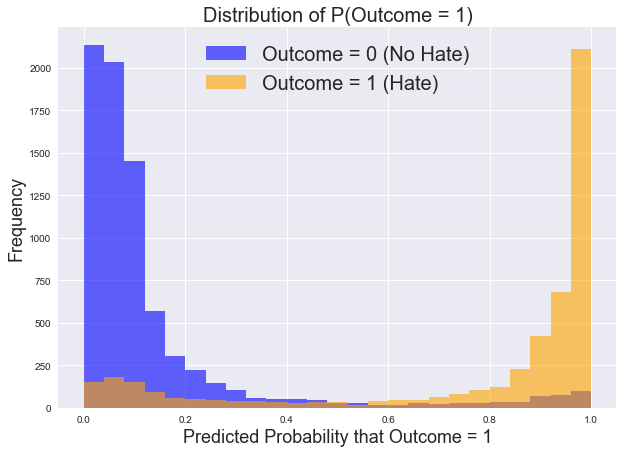

In [125]:
# Create figure for distribution graph
plt.figure(figsize = (10,7))

# Creatinfg two histograms of observations, with blue (left) from nonhate and yellow (right) from hate
plt.hist(pred_df[pred_df['actual'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0 (No Hate)')
plt.hist(pred_df[pred_df['actual'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1 (Hate)')

# Labeling of axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=20)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Creating of legends
plt.legend(fontsize=20);

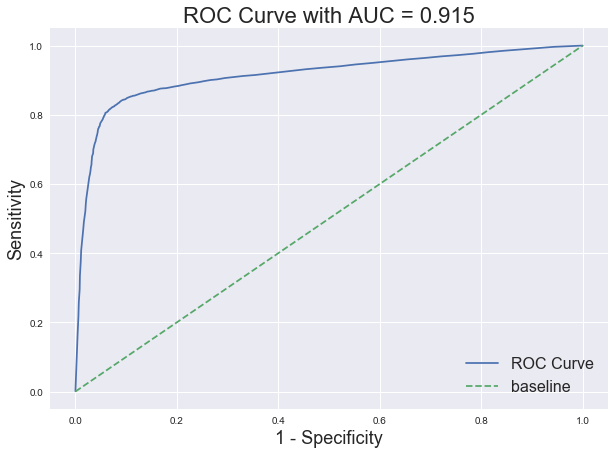

In [126]:
from sklearn.metrics import roc_auc_score

# Creating of figure for AUC ROC graph
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'actual', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'actual', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["actual"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [134]:
print_results(logreg, pred_lr)

LogisticRegression Confusion Matrix:
True Negatives: 7183
False Positives: 503
False Negatives: 920
True Positives: 3984




,precision,recall,f1-score,support
Predict 0,0.886462,0.934556,0.909874,7686.000000
Predict 1,0.887898,0.812398,0.848472,4904.000000
accuracy,0.886974,0.886974,0.886974,0.886974
macro avg,0.887180,0.873477,0.879173,12590.000000
weighted avg,0.887021,0.886974,0.885957,12590.000000


__Save misclassifications to csv__

In [135]:
lr_fn_df.shape

(920, 6)

In [136]:
lr_fn_df.to_csv('../assets/logreg_fn.csv', index=False)

In [137]:
lr_fp_df.shape

(503, 6)

In [138]:
lr_fp_df.to_csv('../assets/logreg_fp.csv', index=False)

#### Analysis of False Negatives

<span style="color:maroon">Warning: There is presence of derogatory comments in this section and is discussed for academic and research purposes. Please skip to the subsequent sections if you find this offensive.</span>

In [150]:
#sampling subset of 10 false negatives
lr_fn_df = pd.read_csv('../assets/logreg_fn.csv')
for i in np.random.choice(lr_fn_df.index, 5):
    display(lr_fn_df.loc[i,'comment'])
    print('\nResponse:')
    print(lr_fn_df.loc[i,'response'])
    print('\n')
    print(f"Probability: {lr_fn_df.loc[i,'pred_probs']}")
    print('----'*10)

"I shouldn't even have to use the /s, it is incredibly obvious that I am being sarcastic either way."


Response:
['This thread is closed. We ask that you all review our user policies and refrain from hate speech of any kind. This is a final warning. Ty.', 'Its inappropriate to use words that directly attack one based on their sexual preferences (incel and faggot) and gender (cunt).', 'Do not discuss hate speech by using hate speech there are ways to avoid this. Name calling also does not add to the conversation.']


Probability: 0.0933714693538914
----------------------------------------


'I don’t know the full details of the IMC shit. I was bored with the Kraut stupidity the first time round so this round holds little interest for me. The name wild goose however I do know. He is a legitimately horrible individual who is butt buddies with Ralph and the other IBS cunts. I believe he was the one who doxed Sargon and celebrated the suicide of the sister of a GG’er back in the day.   Honestly it’s not what he changed his mind to that makes me distrust him. It’s the degree to which he flipped and the time it took to happen. I don’t give him any credibility and doubt every thing he says and does.   You do you mate. Just remember that someone’s actions belie the truth of their words. '


Response:
['Use of the c-word here is not acceptable because it is hurtful and offensive as it denigrates women.', 'Using the term "c---" pejoratively is offensive and should be avoided.']


Probability: 0.007523960445078103
----------------------------------------


".... they're the 'dumbest of the dumb' who believe the insane Left and try to prove they're NOT against being killed by religious imbeciles !"


Response:
['Use of the r-word is unacceptable in discourse as it demeans and insults people with mental disabilities.', 'I like Cindy Lauper and her song Girls Just Want to Have Fun', 'Please avoid expressions that denigrate women or people of other religions.']


Probability: 0.06008171222560287
----------------------------------------


"Sold yourself out dbag. Throwing buzzwords around instead of thinking makes you a inept yet dangerous person. Seek help, there's no shame in mental illness. "


Response:
["Next we need a law where if you're caught over and over lying about these things you go to jail.", "There's no need for that language. This is a warning.", 'Stop using a medical condition as an insult.']


Probability: 0.11629146743911055
----------------------------------------


"She's a big big BIG phony beyond her heritage Claims.  She was a Financial advisor for the Clinton administration.  She audited the Derivative bonds before the Real Estate bubble even ever happened. She found that it was pure garbage and junk and would destroy the Financial health of America if those type of financial vehicles were allowed to be sold.   Had She had just a smidgen of the meddle Trump has, She would have went public. Instead She was told to keep her finding quiet and was kicked up to the Big corner office. Then upgraded on a fast track to be the Senator.   I knew She was the Shittiest person to be entrusted with creating the CFPB. The verbiage in the legalese of most Financial contracts are more oppressive than ever. Companies can legally fuck you over 10 different ways to Sunday. As long as they mention in their contract to read the terms and condition that may be in other supplemental materials like on a Website, or even have to call or email for the hard copy of thos


Response:
["Name calling the people you disagree with isn't going to help solve anything.", 'Removing the foul language will help others to understand your point of view more.', "While an argument can be made on whether certain derogatory terms are applied evenly, it doesn't help to aggressively label someone that way"]


Probability: 0.01147579121017993
----------------------------------------


In [145]:
word_coef[word_coef['word'] == 'negroid']

,word,coeff
5963,negroid,3.985588


The false negatives can be segregated into the following categories highlighted in bold.  

__Subjective__

>'I don’t know the full details of the IMC shit. I was bored with the Kraut stupidity the first time round so this round holds little interest for me. The name wild goose however I do know. He is a legitimately horrible individual who is butt buddies with Ralph and the other IBS c\*\*\*\*. I believe he was the one who doxed Sargon and celebrated the suicide of the sister of a GG’er back in the day.   Honestly it’s not what he changed his mind to that makes me distrust him. It’s the degree to which he flipped and the time it took to happen. I don’t give him any credibility and doubt every thing he says and does.   You do you mate. Just remember that someone’s actions belie the truth of their words. '

What is hate speech is subjective and some of the human labellers might be more offended at certain swear words which are deemed derogatory whereas some might find it more acceptable. 

__Mispelled derogatory terms or joined together__
> 'A f\*\*\*ing life sentence? Jeez, give that lady her p\*\*\*y pass back.'

> "Hell if you’re over here it’s the only word, damn thing fits in just about ever c\*\*\*\*ing sentence you can come up with."

>'The rest of his life in Pakistan? Not so sure that’s a preferable option to being treated like a hero as part of a Moslim gang in some British jail.'

Sometimes the words are joined together or seperated deliberately or accidentally. Since misspellings are not very common, the model does not recognise them as hate speech related. 

__Dubious ones__ 
>"Cool, now we know it's false because you said it.  :D"

>"Half these clowns on here can't even spell philosophy without the spell checker!"

The above ones do not seem to be hate speech in nature and might be due to mislabelling.

__Contextual to the conversation__
> 'Exacly my point, and thats why we have the second amendment so if any of those monkeys try and give me consequences for my speech i can blow them away'

> "Being white just means your better than anyone else and should go the extra length for all the dumb brown people in the world(SJW logic)  Based on various garbage articles I've seen online(vox buzzfeed salon etc)  Black people can't figure out how to be places okkn time so we need to be patient with them. Black people can't figure out basic manners and politeness. Black people are scared of milk. Black peop e need their own little safe spaces so e don't spook them. Black people can't find jobs and should live off the table scraps of white people.  I could go on and on. If you frame it this way, it's pretty clear SJW's are convijnced white people are superior in every way, and shouldn't be held to the same standard. Being black is a mentalcretardation(and any other skin color to)"

> ' Wait until Canadian  women’s muslim owners are fucking them at will and then selling them to the highest bidder!   They will wish they had moved to the United States where a president would protect them! '

> "Sold yourself out dbag. Throwing buzzwords around instead of thinking makes you a inept yet dangerous person. Seek help, there's no shame in mental illness. "

And of course, there will be some comments that do not contain any of the derogatory words and yet are still deemed as hate speech with more context of the conversation. 

#### Analysis of False Positives

<span style="color:maroon">Warning: There is presence of derogatory comments in this section and is discussed for academic and research purposes. Please skip to the subsequent sections if you find this offensive.</span>

In [149]:
#sampling subset of 10 false postives
lr_fp_df = pd.read_csv('../assets/logreg_fp.csv')
for i in np.random.choice(lr_fp_df.index, 10):
    display(lr_fp_df.loc[i,'comment'])
    print('\n')
    print(f"Probability: {lr_fp_df.loc[i,'pred_probs']}")
    print('----'*10)

'Point taken.  When I see gang rape, I think Muzzie.'



Probability: 0.8553899900368416
----------------------------------------


'>You\'re still pretending that there are radical dominionists in the wings, when the reality is that the contemporary right has become substantially more secular and in some ways much more socially liberal than it used to be.  If the contemporary right is becoming more liberal, that doesn\'t mean the contemporary right is changing - it means more people are accepting of liberal values (which the right has traditionally not been). And I fully agree.   But, I honestly think you are trying to paint a picture of a new, improved, updated right-wing - accepting of gays, accepting of personal freedoms when it comes to issues such as abortion etc... which at best, is simply a thinly veneered attempt to attract "new blood" by throwing out some of the ideas that simply aren\'t going to wash in the modern world (eg - Milo being "flamboyantly gay" - while at the same time taking an anti-gay stance on just about every gay rights issue - such as gay marriage which, even though he has indulged in it



Probability: 0.7350872438669452
----------------------------------------


'That is a fair concern. However, I am a hillbilly stuck in Denver. Everytime I hear one of these harpies try to to act like we are evil men because we are white and straight, I feel like reminding them just how dangerous we really are. How easy would it be for you and your buddies to leave many leftist hats on the ground? I know it would not be a challenge on my end.'



Probability: 0.7547324069011335
----------------------------------------


"There are a lot of women who are fucking cunts too, but I still love the women in my life and I know there are a majority out there who aren't dumb cunts. It doesn't mean all women have to apologize for the cunts out there. Fucking shit man, fuck progressives."



Probability: 0.9999936816613868
----------------------------------------


'Is this something that YouTube was actually planning on doing? I ask because the source was Keemstar, who no one should have as a source for anything other than how to be a total cunt. '



Probability: 0.6660993244536081
----------------------------------------


'It reminds me of the "Redneck Revolt" contingent of Antifa. They should probably change their name to Redneck Surrender.'



Probability: 0.8374726632394158
----------------------------------------


'The first three episodes were golden, I was blown away. SBC is far better doing this kind of comedy than scripted film roles. I\'ve been a fan of his since the 11 o\'clock show, and he\'s been receiving the same criticisms since those days - he\'s remained remarkably unfazed.  The show ran out of steam though. The latter half of the season was by no means terrible, but it peaked in those first three episodes. Getting that state senator to walk around saying "nigger", getting those guys dressed up as teenage girls for the Mexican coming out party, opening a brand new state of the art mosque - these were all up there with some of the best work SBC has ever done. There was really nowhere left to go after those bits, they set the bar too high too early. '



Probability: 0.6289210491449319
----------------------------------------


'Well i definitely agree with the controller being superior in some cases, I for example prefer using it in dark souls and some other 2D platformers. Just that this case was a shooter, FPS, on PC and she was saying that controller was better wtf are you using M+KB and that IMO is beyond retarded. '



Probability: 0.7490682692133128
----------------------------------------


'> The people who get called racist, xenophobic or "right-wingers" tend to be the ones who conflate all Muslims with radical Islamists.  Ayaan Hirsi Ali, Maajid Nawaz and even *Tommy Fucking Robinson* frequently make clear they aren\'t talking about all Muslims, and they frequently distinguish between "Islamists" and "most Muslims in the west." They still get called "radical racist xenophobic right-wingers."  >The experience you will gain, backed with factual statistics, will show you that the vast majority of Muslims are peaceful and simply want to be left alone to get on with their lives.   The factual statistics also suggest that a very large percentage of Muslims are socially and theologically conservative, and would favor laws that restrict our civil liberties in the name of their religion. A survey of British Muslims found that a *supermajority* thought homosexuality should be criminalized.  Sure, they aren\'t necessarily *jihadists*. But if you believe in forcing society to live



Probability: 0.9918611748424442
----------------------------------------


'Frankly I think it’s a good thing that racists have to hide their disgusting inhumane views, but sadly that’s changing. We’ve got these idiots on TiA, and cunts with tiki torches and cargo shorts on TV. Mental.  '



Probability: 0.9392706010700892
----------------------------------------


The false positives can be segregated into the following categories highlighted in bold.

__Mislabelled__

>'Point taken.  When I see gang rape, I think Muzzie.'

>'Frankly I think it’s a good thing that racists have to hide their disgusting inhumane views, but sadly that’s changing. We’ve got these idiots on TiA, and c\*\*\*\* with tiki torches and cargo shorts on TV. Mental.  '

>'Is this something that YouTube was actually planning on doing? I ask because the source was Keemstar, who no one should have as a source for anything other than how to be a total c\*\*\*. '

>'It reminds me of the "Redneck Revolt" contingent of Antifa. They should probably change their name to Redneck Surrender.'

The above comments are definitely hate speech and the model did well by being sensitive to such derogatory words and to detect mislabelled comments.  

__Sensitive to strong words__

>'Well i definitely agree with the controller being superior in some cases, I for example prefer using it in dark souls and some other 2D platformers. Just that this case was a shooter, FPS, on PC and she was saying that controller was better wtf are you using M+KB and that IMO is beyond retarded. '

>'The first three episodes were golden, I was blown away. SBC is far better doing this kind of comedy than scripted film roles. I\'ve been a fan of his since the 11 o\'clock show, and he\'s been receiving the same criticisms since those days - he\'s remained remarkably unfazed.  The show ran out of steam though. The latter half of the season was by no means terrible, but it peaked in those first three episodes. Getting that state senator to walk around saying "n\*\*\*\*\*", getting those guys dressed up as teenage girls for the Mexican coming out party, opening a brand new state of the art mosque - these were all up there with some of the best work SBC has ever done. There was really nowhere left to go after those bits, they set the bar too high too early. '

>'That is a fair concern. However, I am a hillbilly stuck in Denver. Everytime I hear one of these harpies try to to act like we are evil men because we are white and straight, I feel like reminding them just how dangerous we really are. How easy would it be for you and your buddies to leave many leftist hats on the ground? I know it would not be a challenge on my end.'

Generally the model is sensitive to derogatory terms and we have trained it to be so to catch more and lower the false negatives. 

"Hillbilly" is a considered a derogatory term in America for people who live in the countryside. However, it is not considered hate speech as he or she is directing it at himself and not at other people, thereby not satisfying the hate speech definition.

Hence, more context will be needed to really acertain if it is indeed hate speech or not. 


__Many top features of the model in one comment__

>"There are a lot of women who are f\*\*\*ing c\*\*\*\* too, but I still love the women in my life and I know there are a majority out there who aren't dumb c\*\*\*\*. It doesn't mean all women have to apologize for the c\*\*\*\* out there. F\*\*\*ing shit man, f\*\*\* progressives."

> '> The people who get called racist, xenophobic or "right-wingers" tend to be the ones who conflate all Muslims with radical Islamists.  Ayaan Hirsi Ali, Maajid Nawaz and even *Tommy Fucking Robinson* frequently make clear they aren\'t talking about all Muslims, and they frequently distinguish between "Islamists" and "most Muslims in the west." They still get called "radical racist xenophobic right-wingers."  >The experience you will gain, backed with factual statistics, will show you that the vast majority of Muslims are peaceful and simply want to be left alone to get on with their lives.   The factual statistics also suggest that a very large percentage of Muslims are socially and theologically conservative, and would favor laws that restrict our civil liberties in the name of their religion. A survey of British Muslims found that a *supermajority* thought homosexuality should be criminalized.  Sure, they aren\'t necessarily *jihadists*. But if you believe in forcing society to live by Islamic norms *even via the ballot box* then you\'re an Islamist ("Jihadists" are Islamists who support terrorism as a means to forcing society to live by Islamic norms).   Yes, there are many Muslims whom are not Islamists. But we need to take the problem seriously. We saw the theocratic nonsense spouted by the religious right back in the George W Bush administration for the *threat it was*, and we didn\'t make excuses for them like "but they\'re nonviolent, they want a democratic process to restrict our rights." Islamists should be viewed with the same suspicion, if not more, that was cast upon the Dominionists.  >When people start making claims that "all" Muslims are jihadists, or being Muslim inherently means you are a violent extremist, or follow an extremist ideology - that\'s when you will get called racist, xenophobic or right-wing.  Again, not even Tommy Robinson supports that viewpoint. In addition, some people are *very eager to conflate* the proposition that "some verses in the Quran and some theological positions that are prominent in the Islamic world logically support Jihadists" with the proposition that "all Muslims are violent extremists." Take a look at how Sam Harris was treated by Ben Affleck.   >Do you have a list of "official" organs of the "establishment left"? I didn\'t know there was such a thing.  Think "major, center-left social-democratic political parties," left-leaning MSM outlets, and most academics. '

Due to the sensitivity of the model, whenever there are many of such words in a comment, it is very highly likely a hate speech comment. However, the first comment might not be really hate speech but it could be subjective and offensive for some. 

Overall, the model did well in predicting if the comments are hate speech or not. However, many of the mislabellings can be avoided with more context as it is one of the hot topics of the NLP space. 

## Deep Learning Modelling

Deep learning even though is complex to understand has its merits in learning more context of the text. We shall see in this section if this can be our answer to less mislabellings due to lack of context. 

_Disclaimer: All of the deep learning models are run on the cloud on the same hate speech dataset due to its complexity of training and utlisation of high compute power. The models are put together here for reference purposes of the project._

In [276]:
import tensorflow as tf


from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, Flatten

In [234]:
print(tf.__version__)

2.0.0


### Deep Learning Pre-processing

We shall use the raw text as its input to let the model learn the context of the comments. 

In [452]:
X=df['text']
y=df['hate']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=28)

In [228]:
X_train.shape

(37771,)

In [469]:
y_train.value_counts()

[23055, 14716]

In [470]:
y_test.value_counts()

0    7686
1    4905
Name: hate, dtype: int64

In [472]:
y.value_counts()

0    30741
1    19621
Name: hate, dtype: int64

In [255]:
X_train_list = X_train.to_list()
y_train_list = y_train.to_list()

X_test_list = X_test.to_list()
y_test_list = y_test.to_list()

In [256]:
X_train_list[:5]

['I do not care for 1 second if you have an issue with my religious beliefs and no amount of internet bullying can stop what happens next.   You are a defective piece of ZioShit. \xa0   @DaTroof',
 "In the US at least, it's actually around an average of 55% of all child abuse, and an average of around 65% of all *fatal* child abuse perpetrated by a parent is perpetrated by the mother (not counting infanticide), nearly twice as much as the father, as per the USDHHS studies on child maltreatment for at least the last 30+ years.  (I stopped digging after going back that far).  From the 2015 study:  Abuse by gender ~   Fatal abuse by relationship ~ ",
 'Especially when she said “that name doesn’t even ring a bell” then immediately says “well I know of him” ....',
 'seems to me that shitty cunts with attitudes are worse than even a retard with a loaded gun, so maybe we should arrest all unhinged democrats, we have that list as well.',
 'Parents Outraged After Drag Queen Named “Jessica L’Who

In [325]:
def encode_comment(comment_list, vocab_size, pad=True, pad_max_len=None):
    if type(comment_list) != list:
        raise Exception(f"comment_list should be list. It was passed in as {type(comment_list)}!")
    #one hot encoding comment list
    encoded_comm = [one_hot(comm, vocab_size) for comm in comment_list]
    counts=[]
    for d in encoded_comm:
        counts.append(len(d))
    if pad:
        # pad documents to a max length
        if pad_max_len==None:
            pad_max_len = np.max(counts)
        padded_comm = pad_sequences(encoded_comm, maxlen=pad_max_len, padding='post')
        return padded_comm
    return encoded_comm

In [326]:
#vocab size per comment
vocab_size = 150
padded_X_train = encode_comment(X_train_list, vocab_size, pad=True)
padded_X_test = encode_comment(X_test_list, vocab_size, pad=True, pad_max_len=1516)

In [329]:
type(padded_X_test)

numpy.ndarray

In [332]:
padded_X_test

array([[112,  52,  76, ...,   0,   0,   0],
       [ 62, 140,  40, ...,   0,   0,   0],
       [ 94,  44,  65, ...,   0,   0,   0],
       ...,
       [  6,  95,  48, ...,   0,   0,   0],
       [ 49,  44, 148, ...,   0,   0,   0],
       [ 94, 143,  73, ...,   0,   0,   0]], dtype=int32)

In [333]:
np.save('padded_X_test', padded_X_test)
np.save('padded_X_train', padded_X_train)

In [331]:
np.load('padded_X_test.npy')

array([[112,  52,  76, ...,   0,   0,   0],
       [ 62, 140,  40, ...,   0,   0,   0],
       [ 94,  44,  65, ...,   0,   0,   0],
       ...,
       [  6,  95,  48, ...,   0,   0,   0],
       [ 49,  44, 148, ...,   0,   0,   0],
       [ 94, 143,  73, ...,   0,   0,   0]], dtype=int32)

In [327]:
padded_X_train.shape

(37771, 1516)

In [328]:
padded_X_test.shape

(12591, 1516)

In [268]:
padded_X_test[:2]

array([[112,  52,  76, ...,   0,   0,   0],
       [ 62, 140,  40, ...,   0,   0,   0]], dtype=int32)

In [307]:
y_train_cat = tf.keras.utils.to_categorical( y_train, num_classes=vocab_size)
y_train_cat[:5]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.,

In [308]:
y_train_cat.shape

(37771, 150)

In [309]:
y_test_cat = tf.keras.utils.to_categorical( y_test, num_classes=vocab_size)

In [310]:
y_test_cat.shape

(12591, 150)

#### Tokenizing and Sequencing

Before the model can be ready to be fed in the comments, it needs to be pre-procesed by tokenizing and sequencing the comments. 

In [459]:
from keras.preprocessing.text import Tokenizer

X=df['text']
y=df['hate']

top_words = 5000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X.values)
X_tok = tokenizer.texts_to_sequences(X.values)

# truncate and pad input sequences
max_review_length = 500
X_tok = pad_sequences(X_tok, maxlen=max_review_length)

LSTM_X_train, LSTM_X_test, LSTM_y_train, LSTM_y_test = train_test_split(X_tok, y.values, stratify=y.values, random_state=28)


In [460]:
LSTM_X_train.shape

(37771, 500)

In [461]:
LSTM_X_test.shape

(12591, 500)

In [462]:
LSTM_X_train[:20]

array([[   0,    0,    0, ...,  538,    5,   88],
       [   0,    0,    0, ...,  827,   51, 1304],
       [   0,    0,    0, ...,    9,   74,    5],
       ...,
       [   0,    0,    0, ...,  161,   75,   29],
       [   0,    0,    0, ...,   13,   81,  107],
       [   0,    0,    0, ..., 4415,  560,  296]], dtype=int32)

In [457]:
np.save('../assets/LSTM_X_test', LSTM_X_test)
np.save('../assets/LSTM_X_train', LSTM_X_train)

In [458]:
np.save('../assets/LSTM_y_train', LSTM_y_train)
np.save('../assets/LSTM_y_test', LSTM_y_test)

These X_test and X_train are padded to the maximum length of 500 to accomodate long comments. 

#### Tokenizing and Sequencing - reducing max_len 

By introducing another version of X_test and X_train sets with a much reduced length, we can eliminate the many padded zeros that are considered noise to the model and let the rest of the words be truncated. 

However, the trade off is that some of the information will be lost.

In [463]:
from keras.preprocessing.text import Tokenizer

top_words = 5000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X.values)
X_tok = tokenizer.texts_to_sequences(X.values)

# truncate and pad input sequences
max_review_length = 50
X_tok = pad_sequences(X_tok, maxlen=max_review_length)

LSTM_X_train, LSTM_X_test, LSTM_y_train, LSTM_y_test = train_test_split(X_tok, y.values, stratify=y.values, random_state=28)


In [464]:
np.save('../assets/LSTM_X_test_max_reduce', LSTM_X_test)
np.save('../assets/LSTM_X_train_max_reduce', LSTM_X_train)

np.save('../assets/LSTM_y_train_max_reduce', LSTM_y_train)
np.save('../assets/LSTM_y_test_max_reduce', LSTM_y_test)

In [465]:
LSTM_X_train.shape

(37771, 50)

__Loading of X and Y for model training__

In [151]:
top_words = 5000

max_review_length = 50

def load_xy_deep(max_len=500):
#to load xy for deep learning
    if max_len == 500:
        #x val
        LSTM_X_test = np.load('../assets/LSTM_X_test.npy')
        LSTM_X_train = np.load('../assets/LSTM_X_train.npy')
        #y val
        LSTM_y_test = np.load('../assets/LSTM_y_test.npy')
        LSTM_y_train = np.load('../assets/LSTM_y_train.npy')
        print(f"loaded {max_len} length x and y")
    elif max_len == 50:
        #x val
        LSTM_X_test = np.load('../assets/LSTM_X_test_max_reduce.npy')
        LSTM_X_train = np.load('../assets/LSTM_X_train_max_reduce.npy')
        #y val
        LSTM_y_test = np.load('../assets/LSTM_y_test_max_reduce.npy')
        LSTM_y_train = np.load('../assets/LSTM_y_train_max_reduce.npy')
        print(f"loaded {max_len} length x and y")
  
    return LSTM_X_test, LSTM_X_train, LSTM_y_test, LSTM_y_train

In [153]:
LSTM_X_test, LSTM_X_train, LSTM_y_test, LSTM_y_train = load_xy_deep(500)

loaded 500 length x and y


__Load Pre-trained word embeddings__

In [10]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
wordvec = KeyedVectors.load_word2vec_format("../assets/GoogleNews-vectors-negative300.bin", binary=True)
# load_word2vec_format('./model/GoogleNews-vectors-negative300.bin', binary=True)  


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [11]:
#vocab size
print(len(wordvec.wv.vocab))
#vector size
wordvec.wv.vector_size

3000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


300

In [12]:
#word with corresponding vector
#wordvec.wv.index2word: word 
#wordvec.wv.syn0: vector
w2v = {w: vec for w, vec in zip(wordvec.wv.index2word, wordvec.wv.syn0)}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [19]:
word_embeddings = (np.random.rand(top_words, 300) - 0.5) / 5.0
for i, word in enumerate(wordvec.wv.index2word):
    try:
        word_embeddings[i] = (w2v.get(word))
    except:
        continue
word_embeddings.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


(5000, 300)

### Modelling

In [279]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### LSTM with embedding layer

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. 

LSTMs consists of the input gate, forget gate and output gate. The input gate controls the sequence going in, the forget gate controls how much sequenced is retained or "forgotten" in the network and the output gate outputs the sequence to the next cell of the network. 
This architecture allows the network to keep relevant information during its learning process. 

The embedding layer helps to convert the sequences into vectors for further processing down the network and related sequences can be closely related in the vector space. The embeddig layer also has weights and will be learnt during the training phase. 

In [ ]:
# create the model
embedding_vecor_length = 10

# define the model
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m])
# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 219,729
Trainable params: 219,729
Non-trainable params: 0
_________________________________________________________________
None


The above neural network consists of the following layers:
- Embedding layer
- LSTM layer
- Dense layer
- Output layer 

The dense layer is fully connected layer to the output layer. Generally, it is a good practice to start with a few layers and then adding more layers based on the results. 

In [ ]:
history = model.fit(LSTM_X_train, LSTM_y_train, epochs=3, verbose=1, batch_size=64, validation_data=(LSTM_X_test, LSTM_y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 37771 samples, validate on 12591 samples
Epoch 1/3
37771/37771 [==============================] - 361s 10ms/sample - loss: 0.3882 - accuracy: 0.8444 - f1_m: 0.7298 - val_loss: 0.3231 - val_accuracy: 0.8914 - val_f1_m: 0.8479
Epoch 2/3
37771/37771 [==============================] - 360s 10ms/sample - loss: 0.3741 - accuracy: 0.8452 - f1_m: 0.7439 - val_loss: 0.3086 - val_accuracy: 0.8939 - val_f1_m: 0.8565
Epoch 3/3
37771/37771 [==============================] - 365s 10ms/sample - loss: 0.2838 - accuracy: 0.8999 - f1_m: 0.8636 - val_loss: 0.3191 - val_accuracy: 0.8883 - val_f1_m: 0.8518


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

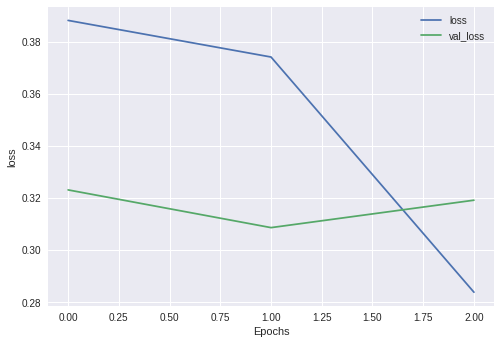

In [ ]:
plot_graphs(history, 'loss')


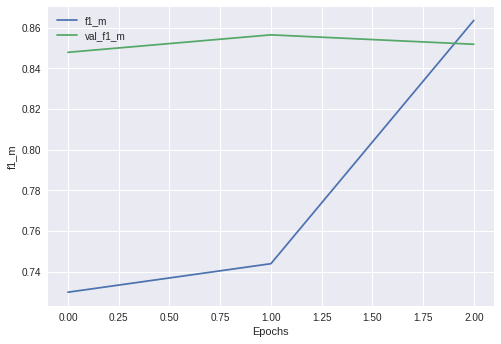

In [ ]:
plot_graphs(history, 'f1_m')

In just 3 epochs, it achieved an validation F1 score of `85.18%` But looking at the validation loss and training loss, it converged at just after 1 and half epochs, with an F1 score between `84.79%` `85.65%`.

#### CNN & LSTM with embedding layer

It is helpful to think of this architecture as defining two sub-models: the CNN (Convolutional Neural Networks) Model for feature extraction and the LSTM Model for interpreting the features across time steps - in this case is sequences of texts. [[1]](https://machinelearningmastery.com/cnn-long-short-term-memory-networks/)



In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model_cnn_lstm.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_cnn_lstm.add(MaxPooling1D())
model_cnn_lstm.add(LSTM(50))
model_cnn_lstm.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the model
model_cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m])
# summarize the model
print(model_cnn_lstm.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 179,755
Trainable params: 179,755
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history_cnn_lstm = model_cnn_lstm.fit(LSTM_X_train, LSTM_y_train, epochs=3, verbose=1, batch_size=64, validation_data=(LSTM_X_test, LSTM_y_test))

Train on 37771 samples, validate on 12591 samples
Epoch 1/3
37771/37771 [==============================] - 202s 5ms/sample - loss: 0.4043 - accuracy: 0.8292 - f1_m: 0.6822 - val_loss: 0.3078 - val_accuracy: 0.8979 - val_f1_m: 0.8612
Epoch 2/3
37771/37771 [==============================] - 200s 5ms/sample - loss: 0.2934 - accuracy: 0.8990 - f1_m: 0.8645 - val_loss: 0.3134 - val_accuracy: 0.8974 - val_f1_m: 0.8612
Epoch 3/3
37771/37771 [==============================] - 200s 5ms/sample - loss: 0.2684 - accuracy: 0.9035 - f1_m: 0.8709 - val_loss: 0.3220 - val_accuracy: 0.8842 - val_f1_m: 0.8495


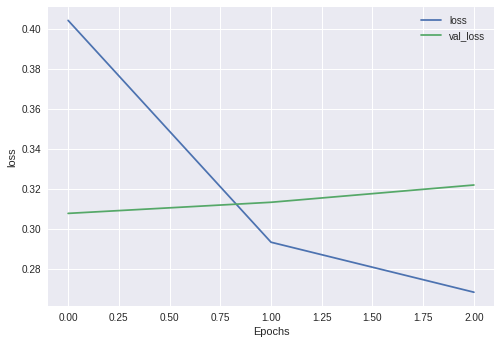

In [ ]:
plot_graphs(history_cnn_lstm, 'loss')

The validation loss and training loss converged at less than an epoch. At the end of an epoch the difference was quite stark at more than 0.1. This is likely due to over training. 

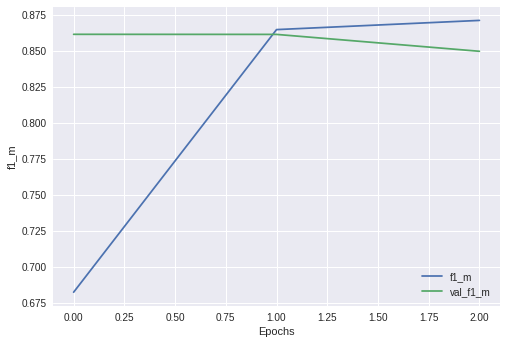

In [ ]:
plot_graphs(history_cnn_lstm, 'f1_m')

The good news is that the F1 score converged slightly before epoch 1. Thereafter both F1 scores "fans out". 

#### Pre-trained Word2Vec LSTM after gridsearch

Having pre-trained word embeddings that is trained on billions of Google news set can aid in representing context of the texts. Advantages include faster training time since the embeddings layer is not trained and better understanding of context most of the time.

Gridsearch was ran to find the optimum dropout rate, number of LSTM and Dense layer neurons and the best optimizer.  

In [ ]:
embedding_vecor_length = wordvec.wv.vector_size
# define the model
model_gs = Sequential()
model_gs.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length, mask_zero=False, weights=[word_embeddings], trainable=False))
model_gs.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_gs.add(Dense(8, activation='relu'))
model_gs.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [ ]:
# compile the model
model_gs.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m])
# summarize the model
print(model_gs.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 8)                 808       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,661,217
Trainable params: 161,217
Non-trainable params: 1,500,000
_________________________________________________________________
None


In [ ]:
y.value_counts(normalize=False)

0    0.610401
1    0.389599
Name: hate, dtype: float64

In [ ]:
def get_class_weights(y):
    majority = max(y.value_counts())
    return  {cls: float(majority/count) for cls, count in enumerate(y.value_counts())}

class_weights = get_class_weights(y)
class_weights

{0: 1.0, 1: 1.5667397176494573}

In [ ]:
history_lstm_gs = model_gs.fit(LSTM_X_train, LSTM_y_train, epochs=10, verbose=1, batch_size=20, class_weight=class_weights ,validation_data=(LSTM_X_test, LSTM_y_test))

Train on 37771 samples, validate on 12591 samples
Epoch 1/10
37771/37771 [==============================] - 121s 3ms/sample - loss: 0.3528 - accuracy: 0.8942 - f1_m: 0.8512 - val_loss: 0.4540 - val_accuracy: 0.8811 - val_f1_m: 0.8310
Epoch 2/10
37771/37771 [==============================] - 120s 3ms/sample - loss: 0.3393 - accuracy: 0.8972 - f1_m: 0.8574 - val_loss: 0.4586 - val_accuracy: 0.8656 - val_f1_m: 0.8163
Epoch 3/10
37771/37771 [==============================] - 120s 3ms/sample - loss: 0.3217 - accuracy: 0.8998 - f1_m: 0.8620 - val_loss: 0.4712 - val_accuracy: 0.8751 - val_f1_m: 0.8251
Epoch 4/10
37771/37771 [==============================] - 121s 3ms/sample - loss: 0.3063 - accuracy: 0.9039 - f1_m: 0.8684 - val_loss: 0.4938 - val_accuracy: 0.8718 - val_f1_m: 0.8218
Epoch 5/10
37771/37771 [==============================] - 120s 3ms/sample - loss: 0.2902 - accuracy: 0.9083 - f1_m: 0.8756 - val_loss: 0.5169 - val_accuracy: 0.8728 - val_f1_m: 0.8227
Epoch 6/10
37771/37771 [======

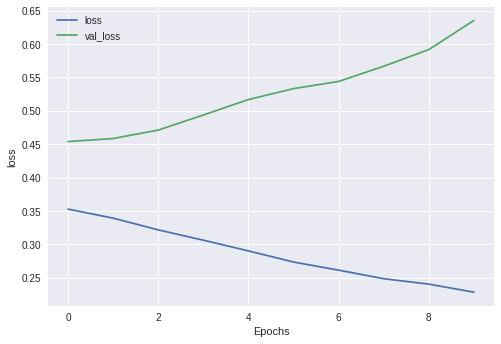

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history_lstm_gs, 'loss')

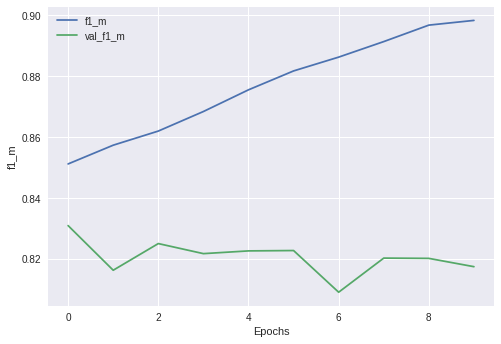

In [ ]:
plot_graphs(history_lstm_gs, 'f1_m')

Even though the F1 score at the end of 10 epochs is the highest at `89.83%` but looking at both the loss and F1 graphs it is severely overtrained and would not generalize well. 

#### Pre-trained Word2Vec LSTM

Since the earlier model was too over fitted, we try by increasing the Dense layer neurons slightly to 32. 

In [ ]:
# define the model
model_dropout = Sequential()
model_dropout.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length, mask_zero=False, weights=[word_embeddings], trainable=False))
model_dropout.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_dropout.add(Dense(32, activation='relu'))
model_dropout.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the model
model_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m])
# summarize the model
print(model_dropout.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 300)          1500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,663,665
Trainable params: 163,665
Non-trainable params: 1,500,000
_________________________________________________________________
None


In [ ]:
history_lstm_dropout = model_dropout.fit(LSTM_X_train, LSTM_y_train, epochs=10, verbose=1, batch_size=64, validation_data=(LSTM_X_test, LSTM_y_test))

Train on 37771 samples, validate on 12591 samples
Epoch 1/10
37771/37771 [==============================] - 483s 13ms/sample - loss: 0.5108 - accuracy: 0.7619 - f1_m: 0.5957 - val_loss: 0.4157 - val_accuracy: 0.8436 - val_f1_m: 0.7577
Epoch 2/10
37771/37771 [==============================] - 478s 13ms/sample - loss: 0.4045 - accuracy: 0.8469 - f1_m: 0.7711 - val_loss: 0.3802 - val_accuracy: 0.8578 - val_f1_m: 0.7875
Epoch 3/10
37771/37771 [==============================] - 480s 13ms/sample - loss: 0.3850 - accuracy: 0.8576 - f1_m: 0.7903 - val_loss: 0.3707 - val_accuracy: 0.8659 - val_f1_m: 0.8015
Epoch 4/10
37771/37771 [==============================] - 479s 13ms/sample - loss: 0.3705 - accuracy: 0.8663 - f1_m: 0.8069 - val_loss: 0.3538 - val_accuracy: 0.8770 - val_f1_m: 0.8228
Epoch 5/10
37771/37771 [==============================] - 479s 13ms/sample - loss: 0.3649 - accuracy: 0.8669 - f1_m: 0.8125 - val_loss: 0.3534 - val_accuracy: 0.8767 - val_f1_m: 0.8241
Epoch 6/10
37771/37771 [=

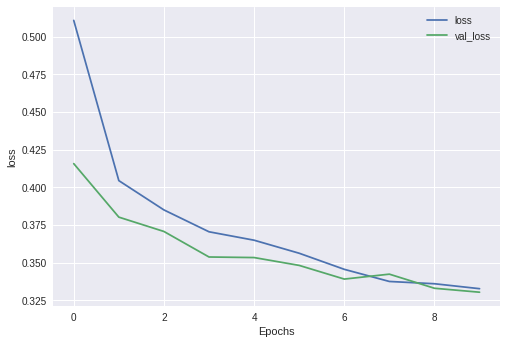

In [ ]:
plot_graphs(history_lstm_dropout, 'loss')

The validation loss and training loss slowly converged epoch 6-7 while steadying at around epoch 8-10. This is a good outcome that shows the model is generalising well. 

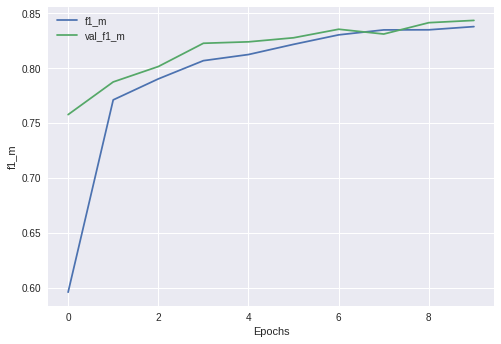

In [ ]:
plot_graphs(history_lstm_dropout, 'f1_m')

The same relationship of the validation and training loss graph can be seen for the F1 score as well. By the end of the 10th epoch, it reached a validation score of `84.36%`.

For the deep learning models, this will be the best generalisable model so far with a decent score.

In [ ]:
# serialize model to JSON
model_dropout_json = model_dropout.to_json()
with open(drive_path + "assets/model_dropout.json", "w") as json_file:
    json_file.write(model_dropout_json)
# serialize weights to HDF5
model_dropout.save_weights(drive_path + "assets/model_dropout.h5")
print("Saved model to disk")

Saved model to disk


### BERT Modelling

BERT is a deep learning model that has given state-of-the-art results on a wide variety of natural language processing tasks. It stands for Bidirectional Encoder Representations for Transformers. It has been pre-trained on Wikipedia and BooksCorpus and requires task-specific fine-tuning. 

BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. [[2]](https://arxiv.org/pdf/1810.04805.pdf)

BERT is a multi-layer bidirectional Transformer encoder and consists of the following:

- 12 - 24 Transformer layers (transformer blocks)
- 12 - 16 Attention heads
    - an attention mechanism that learns contextual relations between words (or sub-words) in a text
    - the Transformer encoder reads the entire sequence of words at once, learning context left and right of a word
- More than 110 million parameters. [[3]](https://yashuseth.blog/2019/06/12/bert-explained-faqs-understand-bert-working/)

It learns context using two strategies:

__Masked LM__

In the input, it masks 15% of the words, run the entire sequence through a deep bidirectional Transformer encoder, and then predict only the masked words, based on context of non-masked words.

__Next-sentence Prediction__

In the BERT training process, the model receives pairs of sentences as input and learns to predict if the second sentence in the pair is the subsequent sentence in the original document. During training, 50% of the inputs are a pair in which the second sentence is the subsequent sentence in the original document, while in the other 50% a random sentence from the corpus is chosen as the second sentence. [[4]](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)

In [3]:
import ktrain
from ktrain import text

Using TensorFlow backend.


using Keras version: 2.2.4


In [ ]:
# get hate speech dataset
import tensorflow as tf
drive_path = './drive/My Drive/Colab Notebooks/'
df = pd.read_csv(drive_path + 'assets/comb_lemma.csv')


In [154]:
df.head(2)

,id,text,hate,response,red,tokens,lemma,tok_lemma,pos
0,e8q18lf,A subsection of retarded Hungarians? Ohh boy. ...,1,"[""I don't see a reason why it's okay to insult...",1,"[subsection, retarded, hungarians, ohh, boy, b...",a subsection of retarded Hungarians ? ohh boy ...,subsection retard hungarians ohh boy brace liv...,DT NN IN JJ NNPS . NN NN . NN IN DT JJ NNP VBG...
1,e8q9w5s,Hiii. Just got off work. 444 is mainly the typ...,0,nil,1,"[hiii, got, work, mainly, typa, guys, imagine,...",hiii . just get off work . 444 be mainly the t...,hiii get work mainly typa guy imagine write -P...,UH . RB VBD RP NN . CD VBZ RB DT NN NNS PRP VB...


The below code was adapted from https://github.com/amaiya/ktrain.

#### Load and Preprocess the Dataset

The `texts_from_df` function will load the training and validation data from the specified folder and automatically preprocess it according to BERT's requirements.  In doing so, the BERT model and vocabulary will be automatically downloaded.

In [8]:
(x_train, y_train), (x_test, y_test), preproc=text.texts_from_df(df,
                                                                 text_column='text',
                                                                 label_columns=['hate'],
                                                                 max_features=30000,
                                                                 maxlen=50,
                                                                 preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


In [10]:
x_train[:10]

[array([[ 101, 2517, 2011, ...,    0,    0,    0],
        [ 101, 1045, 1005, ..., 2342, 2000,  102],
        [ 101, 1997, 2607, ...,    0,    0,    0],
        ...,
        [ 101, 2009, 1005, ...,    0,    0,    0],
        [ 101, 2061, 2017, ...,    0,    0,    0],
        [ 101, 2027, 1005, ...,  102,    0,    0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

#### Load a pre-trained BERT model and wrap it in a `ktrain.Learner` object

This step can be condensed into a single line of code, but we execute it as two lines for clarity. (You can ignore the deprecation warnings arising from Keras 2.2.4 with TensorFlow 1.14.0.)  

In [11]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model,train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=6,)

Is Multi-Label? False
maxlen is 50
done.


In [ ]:
import numpy as np
columns=['rating_mixture of true and false','rating_mostly false','rating_mostly true','rating_no factual content'],

counter_weight={}
weights=df['hate'].value_counts()

for n,wght in enumerate(weights):
    counter_weight[n]=(np.max(weights)/wght)
  

In [ ]:
weights=df['target'].value_counts()
weights

0    1090
1     290
Name: target, dtype: int64

In [14]:
counter_weight

{0: 1.0, 1: 1.5667397176494573}

#### Train and Fine-Tune the Model on the dataset

We employ the `learner.fit_onecycle` method in *ktrain* that employs the use of a [1cycle learning  rate schedule](https://arxiv.org/pdf/1803.09820.pdf).  We use a learning rate of 2e-5 based on recommendations from [the original paper](https://arxiv.org/abs/1810.04805).

As can be seen, we achieve a **88.19% validation accuracy** in a single epoch.

In [15]:
learner.autofit(2e-5, 10,early_stopping=1,checkpoint_folder=drive_path + 'BERTModelCheckpoint',class_weight=counter_weight)



begin training using triangular learning rate policy with max lr of 2e-05...
Train on 45325 samples, validate on 5037 samples
Epoch 1/10
45325/45325 [==============================] - 985s 22ms/step - loss: 0.4387 - acc: 0.8639 - val_loss: 0.3180 - val_acc: 0.8819
Epoch 2/10
45325/45325 [==============================] - 977s 22ms/step - loss: 0.3634 - acc: 0.8908 - val_loss: 0.3203 - val_acc: 0.8779
Restoring model weights from the end of the best epoch
Epoch 00002: early stopping
Weights from best epoch have been loaded into model.


In prevention of the BERT model to be overfitted, we have included an early stopping callback so that it will save the weights and stop at the desired Epoch. 

In this case it stopped at Epoch 2 achieving a validation accuracy of `87.79%.` and macro average validation F1 score of `87%`.

In [16]:
learner.validate(val_data=(x_test, y_test), class_names=['non-hate','hate'])

              precision    recall  f1-score   support

    non-hate       0.89      0.91      0.90      3079
        hate       0.86      0.83      0.85      1958

    accuracy                           0.88      5037
   macro avg       0.88      0.87      0.87      5037
weighted avg       0.88      0.88      0.88      5037



array([[2816,  263],
       [ 332, 1626]])

As our metrics to prioritise are F1 score and recall, it had done a great job in reducing its False Negatives of achieving a macro average of 87% for both F1 Score and recall. 

However, it is not doing so well for recall in the hate class.

Furthermore, BERT model can be complex when you think about how it is actually classifying according to the data and the pre-trained BERT model. 

# Limitations and Future Work

The challenge faced by automatic hate speech detection is the subjectivity of whether a comment is considered hate speech or not. This can be better managed by having more people labelling these datasets to cross reference and to take a majority vote.

Another challenge is that many new urban words that are deemed derogatory are coined every few years or decades and the models that are developed now might be obsolete in the future. Constant training of new data sets will thus be paramount in overriding this problem.

As with any hate speech classification problem, context is needed to determine whether it is hate speech or not in many cases. Looking at the context of the text of how a word is being used and linguistic features will be a better way of understanding text. Of course, understanding sarcasm is one of the ongoing research which will help immensely in NLP tasks and higher accuracy rates. Therefore, more models have to be developed to train on learning to read context left or right of the target word or having "multiple views" of the same comment by using Multi-view ensemble stacking models.

# Conclusions

With the rise of social media and users being able to stay anonymous, hate speech detection is ever important in the digital age. 

We present current approaches to this classification task and also explored different techniques including deep learning models and state-of-the-art models such as BERT. 

| Classifier                              | F1 score | Recall |
|-----------------------------------------|----------|--------|
| Logistic Regression                     | **87.91%**   | **87.35%** |
| Logistic Regression with balanced class | 87.64%   | 87.33% |
| LSTM - word embeddings on dataset       | 85.18%   |    -   |
| LSTM & CNN - word embeddings on dataset | 84.95%   |    -   |
| LSTM 1 - pre-trained word embeddings    | 81.75%   |    -   |
| LSTM 2 - pre-trained word embeddings    | 84.36%   |    -   |
| BERT                                    | 87%      | 87%    |

Even though context is important in determining if a comment is hate speech or not, the simplest classifier, Logistic Regression, is actually the best performing one. This goes to show that at times, the simpler the classifier the better in terms of interpretability and it has made it easier to choose the best model with a superior F1 score.

In comparison with the state-of-the-art NLP BERT model, Logistic Regression was still able to perform very well while generalises well for this specific task. It is no wonder why Logistic Regression has been around for many years and continues to be widely used.